### Introdução

**Problema de Estudo:** Deteção de Reviews Spam em Produtos de Moda e Acessórios na Amazon.

Pretende-se que seja implementada uma solução computacional para estudo e análise de dados em larga escala.

### Contextualização do problema

Neste projeto, pretende-se desenvolver e implementar um modelo computacional capaz de identificar reviews de produtos da categoria "Clothing, Shoes, and Jewelry" na Amazon como spam ou não spam. O objetivo é diferenciar reviews genuínas de tentativas de manipulação através de avaliações falsas que podem enganar consumidores e distorcer a percepção do produto. Este problema é particularmente desafiador devido à subjetividade e variabilidade do texto das reviews, bem como às diferentes motivações por trás das reviews spam.

**Dados**

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pyspark.sql import SparkSession

# Criar uma sessão Spark
spark = SparkSession.builder \
    .appName("Clothing_Shoes_and_Jewelry_Analysis") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/01 03:44:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Caminho para o arquivo JSON
file_path = "Clothing_Shoes_and_Jewelry.json"

# Carregar o dataset
df = spark.read.json(file_path)

In [5]:
# Mostrar as primeiras 5 linhas do dataframe
df.show(5)

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  0.0| [0, 1]|    1.0|My 3-yr-old daugh...|03 21, 2013| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    5.0|Perfect red tu

In [6]:
# Ver a estrutura dos dados
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
# Verificar o número de linhas do dataframe
rows = df.count()
rows

5504331

In [8]:
# Verificar o número de colunas do dataframe
cols = len(df.columns)
cols

12

In [9]:
# Colunas do dataframe
cols = df.columns
cols

['_id',
 'asin',
 'category',
 'class',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

**'_id':** Identificador único de cada review

**'asin':** Amazon Standard Identification Number, que é um identificador único para produtos na plataforma da Amazon

**'category':** Categoria do produto da review, que indica a que segmento do mercado o produto pertence, como roupas, sapatos ou joias

**'class':** Distingue reviews como spam (1.0) ou não spam (0.0)

**'helpful':** Array que contém dois números, onde o primeiro indica quantas pessoas acharam a review útil e o segundo quantas pessoas votaram na utilidade da review

**'overall':** Nota geral dada ao produto pelo usuário

**'reviewText':** Texto completo da review escrita pelo usuário

**'reviewTime':** Data em que a review foi publicada

**'reviewerID':** Identificador único da pessoa que escreveu a avaliação

**'reviewerName':** Nome ou pseudonimo do revisor, conforme apresentado na Amazon no momento da review

**'summary':** Resumo da review, que é uma breve descrição ou título que foi dada na avaliação

**'unixReviewTime':** Representação em timestamp UNIX da data de publicação da review

In [10]:
# Verificar os NA
from pyspark.sql.functions import col, isnull, when, count

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|_id|asin|category|class|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|  0|   0|       0|    0|      0|      0|         0|         0|         0|       13180|      0|             0|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+



### Preparação dos Dados

- Limpeza: duplicados, valores ausente
- Transformação dos dados: normalizar o texto (remover pontuações, passar o texto para minusculas, ...), converter a data da review para formato timestamp

**1. Limpeza dos Dados**

In [11]:
# Remover os duplicados recorrendo ao método dropDuplicates
df = df.dropDuplicates()
df.show()

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13229b741a2384...|B0008EOEPK|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Lee straight leg,...| 01 1, 2014|A2HJ1VX57R6M6L|         Smiling Bob|     Excellent Jeans|    1388534400|
|{5a132298741a2384...|B00075ZYRW|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Fits 3x. After wa...| 01 1, 2014|A3VTTTYIB5BANY|           fabfamily|liked them. order...|    1388534400|
|{5a132296741a2384...|B00023JSDA|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|The quality/wo

https://www.kaggle.com/code/abhilashsampath/amazon-review-spam-detection

In [13]:
#Remover caracteres especiais da coluna 'id'
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace


cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13229b741a2384e...|B0008EOEPK|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Lee straight leg,...| 01 1, 2014|A2HJ1VX57R6M6L|         Smiling Bob|     Excellent Jeans|    1388534400|
|5a132298741a2384e...|B00075ZYRW|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Fits 3x. After wa...| 01 1, 2014|A3VTTTYIB5BANY|           fabfamily|liked them. order...|    1388534400|
|5a132296741a2384e...|B00023JSDA|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|The quality/wo

In [14]:
# Remover colunas que não são necessárias para o problema em questão
cleaned_df = cleaned_df.drop( 'category', 'asin' , 'reviewerID', 'reviewerName') 

cleaned_df.show()

+--------------------+-----+-------+-------+--------------------+-----------+--------------------+--------------+
|                 _id|class|helpful|overall|          reviewText| reviewTime|             summary|unixReviewTime|
+--------------------+-----+-------+-------+--------------------+-----------+--------------------+--------------+
|5a13229b741a2384e...|  1.0| [0, 0]|    4.0|Lee straight leg,...| 01 1, 2014|     Excellent Jeans|    1388534400|
|5a132298741a2384e...|  1.0| [0, 0]|    4.0|Fits 3x. After wa...| 01 1, 2014|liked them. order...|    1388534400|
|5a132296741a2384e...|  1.0| [1, 1]|    4.0|The quality/workm...|01 10, 2007|     Garnet Necklace|    1168387200|
|5a132298741a2384e...|  1.0| [0, 0]|    5.0|These are perfect...|01 10, 2013|Perfect comfy fit...|    1357776000|
|5a132294741a2384e...|  1.0| [0, 1]|    5.0|I bought two of t...|01 10, 2013|A Perfect First W...|    1357776000|
|5a132296741a2384e...|  1.0| [2, 2]|    5.0|I had this watch ...|01 10, 2013|Excelent wa

In [15]:
# Renomear as colunas 'overall' e '-id' 
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")
            
            
             

In [16]:
cleaned_df.show()

+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+
|                  id|class|helpful|productRating|          reviewText| reviewTime|             summary|unixReviewTime|
+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+
|5a13229b741a2384e...|  1.0| [0, 0]|          4.0|Lee straight leg,...| 01 1, 2014|     Excellent Jeans|    1388534400|
|5a132298741a2384e...|  1.0| [0, 0]|          4.0|Fits 3x. After wa...| 01 1, 2014|liked them. order...|    1388534400|
|5a132296741a2384e...|  1.0| [1, 1]|          4.0|The quality/workm...|01 10, 2007|     Garnet Necklace|    1168387200|
|5a132298741a2384e...|  1.0| [0, 0]|          5.0|These are perfect...|01 10, 2013|Perfect comfy fit...|    1357776000|
|5a132294741a2384e...|  1.0| [0, 1]|          5.0|I bought two of t...|01 10, 2013|A Perfect First W...|    1357776000|
|5a132296741a2384e...|  1.0| [2, 2]|    

In [17]:
# Placing the number of votes received as a metric from Helpful
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])
# cleaned_df.show()

In [18]:
# Modifying the originally 'helpful' column to a float value showcasing No. of people who found it helpful among the total people that viewed it

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  # or any other value that makes sense in the context
    except:
        return None

# UDF registration
ratio_udf = udf(helpful_ratio, FloatType())

# Apply the UDF to the DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))

In [22]:
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [23]:
cleaned_df.columns

['id',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

In [24]:
# Converter a coluna 'reviewTime' para o formato timestamp, assumindo que a data esteja no formato MM/dd/yyyy
from pyspark.sql.functions import to_timestamp

cleaned_df = cleaned_df .withColumn("reviewTime", to_timestamp("reviewTime", "MM/dd/yyyy"))
cleaned_df .show()

+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------+-------------+
|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|             summary|unixReviewTime|reviewUpvotes|
+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------+-------------+
|5a13229b741a2384e...|  1.0|              0.0|          4.0|Lee straight leg,...|      NULL|     Excellent Jeans|    1388534400|            0|
|5a132298741a2384e...|  1.0|              0.0|          4.0|Fits 3x. After wa...|      NULL|liked them. order...|    1388534400|            0|
|5a132296741a2384e...|  1.0|            100.0|          4.0|The quality/workm...|      NULL|     Garnet Necklace|    1168387200|            1|
|5a132298741a2384e...|  1.0|              0.0|          5.0|These are perfect...|      NULL|Perfect comfy fit...|    1357776000|            0|

**1.1 reviewText**

In [98]:
import re
import pyspark.sql.functions as F

# Converter todos os caracteres para minúsculas
cleaned_df = cleaned_df.withColumn('reviewText', F.lower(cleaned_df['reviewText']))

# Remover código HTML
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '<[^>]+>', ''))

# Remover URLs
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], 'http\S+|www\S+|https?\:\/\/\S+', ''))

# Remover menções a usuários (não é comum em reviews da Amazon)
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '@\w+', ''))

# Remover hashtags (não é comum em reviews da Amazon)
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '#\w+', ''))

# Remover entidades HTML (&amp;, &lt;, etc.)
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '&\w+;', ''))

# Substituir caracteres não alfanuméricos e pontuação por um espaço em branco
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '[^\w\s]', ' '))

# Remover números (avaliações numéricas, preços, etc.)
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\d+', ''))

# Substituir dígitos por um espaço em branco
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\d', ' '))

# Remover espaços múltiplos e linhas novas
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\s+', ' '))

# Remover espaços no início e no fim
cleaned_df = cleaned_df.withColumn('reviewText', F.trim(cleaned_df['reviewText']))

# cleaned_df.show(truncate=False)


+------------------------+-----+-----------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------------------------------------+--------------+-------------+
|id                      |class|helpfulTotalRatio|productRating|reviewText                                                                                                                     

**1.2 summary**

In [100]:
from pyspark.sql.functions import col, lower, regexp_replace
cleaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))
cleaned_df.show()

+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------+-------------+
|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|             summary|unixReviewTime|reviewUpvotes|
+--------------------+-----+-----------------+-------------+--------------------+----------+--------------------+--------------+-------------+
|5a13229b741a2384e...|  1.0|              0.0|          4.0|lee straight leg ...|      NULL|     excellent jeans|    1388534400|            0|
|5a132298741a2384e...|  1.0|              0.0|          4.0|fits x after wash...|      NULL|liked them ordere...|    1388534400|            0|
|5a132296741a2384e...|  1.0|            100.0|          4.0|the quality workm...|      NULL|     garnet necklace|    1168387200|            1|
|5a132298741a2384e...|  1.0|              0.0|          5.0|these are perfect...|      NULL|perfect comfy fit...|    1357776000|            0|

**Construção do modelo com Algoritmos de Machine Learning**

**Modelo 1: Regressão Logística**

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

'''
Verificar se o texto tem links e criar coluna containsLink com 1 se tiver link e 0 se não tiver
Fazer o tratamento de texto depois de fazer feature engineering
'''

spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()

# Presumindo que os seus dados estão num ficheiro JSON e têm as colunas 'reviewText' e 'class'
file_path = "Clothing_Shoes_and_Jewelry.json"

# Carregar o conjunto de dados
df = spark.read.json(file_path)

df = df.sample(fraction=0.1, seed=12345)

distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0
    except:
        return None

ratio_udf = udf(helpful_ratio, FloatType())

def feature_engineering(df):
    # Fase 1 Limpeza de Dados
    # I Remover caracteres especiais do id
    df = df.withColumn("_id", col("_id").getField("$oid"))
    df = df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

    # II Eliminar colunas desnecessárias
    df = df.drop('category')

    # III Renomear algumas colunas para melhorar a qualidade de vida
    df = df.withColumnRenamed("overall", "productRating")\
           .withColumnRenamed("_id", "id")

    # IV Colocar o número de votos recebidos como uma métrica de útil
    df = df.withColumn('reviewUpvotes', col('helpful')[0])

    # V Modificar a coluna original 'helpful' para um valor float que mostra o número de pessoas que acharam útil entre o total de pessoas que visualizaram
    df = df.withColumn('helpful', ratio_udf(col('helpful')))
    df = df.withColumnRenamed("helpful", "helpfulTotalRatio")

    # VI Avaliar o comprimento da revisão e do resumo
    df = df.withColumn('reviewLength', length(df['reviewText']))
    df = df.withColumn('summaryLength', length(df['summary']))

    # VII Avaliar se uma revisão foi publicada no fim de semana ou não
    df = df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))
    df = df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

    # VIII Criar Popularidade do Produto a partir da contagem de revisões
    product_popularity_df = df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
    df = df.join(product_popularity_df, on='asin', how='left')

    product_avg_rating_df = df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
    df = df.join(product_avg_rating_df, on='asin', how='left')

    # IX Agrupar a helpfulTotalRatio
    bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
    df = bucketizer.setHandleInvalid("keep").transform(df)

    df = df.withColumn("helpfulRatioCategory", 
                       F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                        .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                        .otherwise("High"))

    df = df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))
    df = df.withColumn('containsLink', (F.col('reviewText').like('%http%')).cast('integer'))

    return df

def text_processing(df):
    # VI Remover caracteres especiais e converter para minúsculas
    df = df.withColumn('reviewText', F.lower(df['reviewText']))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '<[^>]+>', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], 'http\\S+|www\\S+|https?://\\S+', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '@\\w+', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '#\\w+', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '&\\w+;', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '[^\\w\\s]', ' '))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\d+', ''))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\d', ' '))
    df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\s+', ' '))
    df = df.withColumn('reviewText', F.trim(df['reviewText']))

    df = df.withColumn('summary', F.lower(df['summary']))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '<[^>]+>', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], 'http\\S+|www\\S+|https?://\\S+', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '@\\w+', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '#\\w+', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '&\\w+;', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '[^\\w\\s]', ' '))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\d+', ''))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\d', ' '))
    df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\s+', ' '))
    df = df.withColumn('summary', F.trim(df['summary']))

    return df

# Load and sample the dataset
df = spark.read.json(file_path)
df = df.sample(fraction=0.1, seed=12345)

# Display a few samples of each label
distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)

# Apply feature engineering
df = feature_engineering(df)

# Apply text processing after feature engineering
df = text_processing(df)

# Show the final DataFrame
df.show()

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|  reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR| aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [3, 4]|    4.0|I ordered this fo...|03 16, 2010|A3Q6CTO56DJ8UZ|Amazing Amazon|       Good Quality!|    1268697600|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|I just got this t...|10 24, 2013|A2F9MVWWC0I

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|  reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR| aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [3, 4]|    4.0|I ordered this fo...|03 16, 2010|A3Q6CTO56DJ8UZ|Amazing Amazon|       Good Quality!|    1268697600|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|I just got this t...|10 24, 2013|A2F9MVWWC0I

+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+-----------------+--------------------+----------------+------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity| avgProductRating|helpfulRatioCategory|containsQuestion|containsLink|
+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+-----------------+--------------------+----------------+------------+
|0000031887|5a132293741a2384e...|  1.0|            100.0| 

+-----+------+
|class| count|
+-----+------+
|  0.0|116697|
|  1.0|433782|
+-----+------+



+-----+-----+
|class|count|
+-----+-----+
|  0.0|93481|
|  1.0|93209|
+-----+-----+

Number of rows after sampling: 186690


24/06/02 19:32:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:55 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/02 19:32:59 WARN DAGScheduler: Broadcasting larg

Test Accuracy = 0.80


24/06/02 19:33:16 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


Class 1.0:
  Precision = 0.81
  Recall = 0.80
  F1 Score = 0.80
Class 0.0:
  Precision = 0.80
  Recall = 0.80
  F1 Score = 0.80


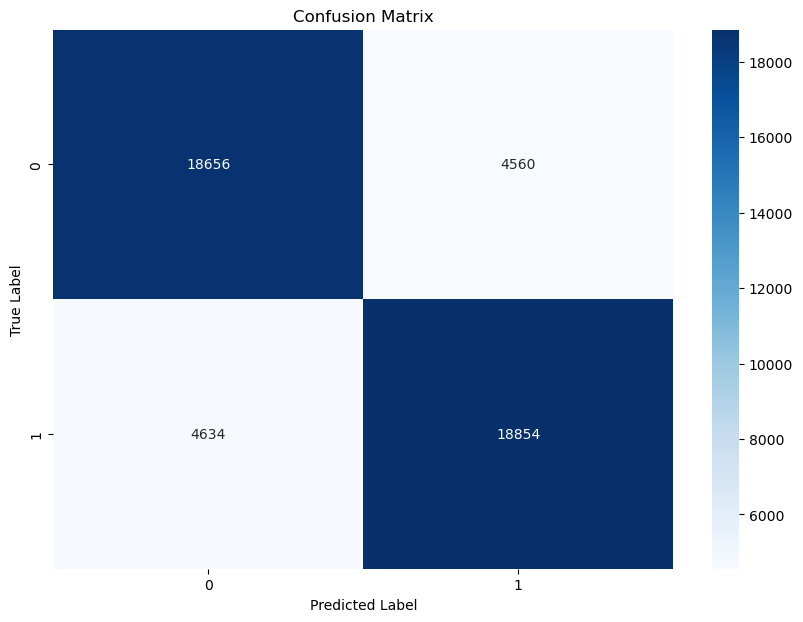

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.functions import to_timestamp, col, regexp_replace
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.storagelevel import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Checking for class imbalance
class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()

# # Undersample the majority class
min_class_count = class_distribution.agg({"count": "min"}).collect()[0][0]

# print("Minimum class count:", min_class_count)

undersampled_df = df.groupBy("class").applyInPandas(
    lambda pdf: pdf.sample(n=min_class_count, random_state=42) if len(pdf) > min_class_count else pdf,
    schema=cleaned_df.schema
)

# Pre-processing stages
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Logistic Regression model
lr = LogisticRegression(labelCol="class")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Persist DataFrame to disk to save memory
undersampled_df.persist(StorageLevel.MEMORY_AND_DISK)

# Split the data into training and testing sets
train_df, test_df = undersampled_df.randomSplit([0.8, 0.2], seed=42)

count_classes = train_df.groupBy("class").count().orderBy("class")
count_classes.show()

print("Number of rows after sampling:", train_df.count())

# Train the model using the training data
model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Stop the Spark session
spark.stop()

### NOTAS

• Por questões de produtividade, devem ser considerados dois conjuntos de dados aquando do desenvolvimento da solução. Assim, para além dos dados originais na sua integra, deve ser utilizado um conjunto de dados de menor dimensão (sub-conjunto dos anteriores), para o caso de tarefas intensivas e frequentes, inerentes ao próprio processo de desenvolvimento da solução.

• Cada notebook (ou módulo) deverá ser autónomo em termos de fontes de dados. Sugere se que estruturem o código por forma a ler e gravar os dados entre cada uma das etapas do projeto. Isto é particularmente importante para a parte da visualização: a geração
de um gráfico ou tabela não deverá implicar a realização da simulação/processamento no mesmo instante. Preferencialmente deverá importar os dados já processados a partir de ficheiros.

### Bibliografia

In [5]:
cleaned_df.show()


+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+-----------------+--------------------+----------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity| avgProductRating|helpfulRatioCategory|containsQuestion|
+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+-----------------+--------------------+----------------+
|0000031887|5a132293741a2384e...|  1.0|            100.0|          4.0|this was a really...|     

https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam/data?select=Clothing_Shoes_and_Jewelry     https://ieeexplore.ieee.org/abstract/document/9027828